# Case Study Analysis Notebook

The purpose of this code is to create a set of graphs based on one shapefile.  It is a combination of many of the other notebooks consolidated into this one.

To run this code, you need the following files in the appropriate folders
 - Data/Input_files
   > Master_ADWR_database_noduplicates.shp
   > Master_ADWR_database_water.shp
   > Yearly_DroughtIndices_updated12032023.csv
 - Data/Output_files
   > Wells55_GWSI_WLTS_DB_annual_updated_thresh15outliersdeleted.csv
 - Data/Shapefiles
   > Any shapefiles of your choosing

In [1]:
# Packages and paths
# %%
from optparse import Values
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
import datetime
from matplotlib.transforms import Bbox
import numpy as np
import pandas as pd
from shapely.geometry import box
import geopandas as gp
#import earthpy as et
import scipy.stats as sp
from scipy.stats import kendalltau, pearsonr, spearmanr
import pymannkendall as mk
import Custom_functions as cf

# Local paths
datapath_local = '../Data'
inputpath_local = '../Data/Input_files'
outputpath_local = '../Data/Output_files/'
shapepath_local = '../Data/Shapefiles/'
figurepath = '../Data/Figures/'

# Some functions
def kendall_pval(x,y):
        return kendalltau(x,y)[1]
    
def pearsonr_pval(x,y):
        return pearsonr(x,y)[1]
    
def spearmanr_pval(x,y):
        return spearmanr(x,y)[1]

In [2]:
# %% Creating colors
c_1 = '#8d5a99' # Reservation
c_2 = "#d7191c" # Regulated with CAP (Water Category Color)
c_3 = '#e77a47' # Regulated without CAP (Water Category Color)
c_4 = '#2cbe21' # Lower CO River - SW (Water Category Color)
c_5 = '#2f8c73' # Upper CO River - Mixed (Water Category Color)
c_6 = '#6db7e8' # SE - GW
c_7 = '#165782' # NW - GW (Water Category color)
c_8 = '#229ce8' # SC - GW
c_9 = '#1f78b4' # NE - GW
c_10 = '#41bf9e' # N - Mixed
c_11 = '#7adec4' # C - Mixed
drought_color = '#ffa6b8'
wet_color = '#b8d3f2'

reg_colors = [c_2,c_7]
georeg_colors = [c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11]
SW_colors = [c_2,c_3,c_4,c_5,c_7]

bar_watercatc = [c_2,c_3,c_4,c_5,c_7]


# Color blind palette
# https://jacksonlab.agronomy.wisc.edu/2016/05/23/15-level-colorblind-friendly-palette/
blind =["#000000","#004949","#009292","#ff6db6","#ffb6db",
 "#490092","#006ddb","#b66dff","#6db6ff","#b6dbff",
 "#920000","#924900","#db6d00","#24ff24","#ffff6d"]

# Matching new map

grace_color = '#A92B2A'
az_wells_color = '#1D4E77'

cap = '#77A8A5' #'#C6652B'
cap_secondary = '#004D40'
# noCAP = '#EDE461' # This is one from the map
noCAP = '#CCC339' # This color but darker for lines
GWdom = '#3B76AF'
mixed = '#6EB2E4'
swdom = '#469B76'

In [3]:
# %% Drought dictionary
DROUGHT_YEARS = {
        # 1:[1989,1990]
        # ,2:[1996]
        3:[2002,2003]
        ,4:[2006,2007]
        ,5:[2012,2013,2014]
        ,6:[2018]
        ,7:[2021]}

print(DROUGHT_YEARS)

{3: [2002, 2003], 4: [2006, 2007], 5: [2012, 2013, 2014], 6: [2018], 7: [2021]}


In [4]:
#%% Pre-drought
# PREDROUGHT_YEARS = {1:[1988]
#         ,2:[1995]
#         ,3:[2001]
#         ,4:[2005]
#         ,5:[2011]
#         ,6:[2017]}

PREDROUGHT_YEARS = {1:[*range(1975,1988,1)]
        ,2:[*range(1991,1995,1)]
        ,3:[*range(1997,2001,1)]
        ,4:[*range(2004,2005,1)]
        ,5:[*range(2006,2011,1)]
        ,6:[*range(2015,2017,1)]}

print(PREDROUGHT_YEARS)

{1: [1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987], 2: [1991, 1992, 1993, 1994], 3: [1997, 1998, 1999, 2000], 4: [2004], 5: [2006, 2007, 2008, 2009, 2010], 6: [2015, 2016]}


Read in the main databases.  You only have to do this once.

Master Database might take a while (~5-7 minutes).

In [5]:
# Read in the main Static Database

filename_mdb_nd = 'Master_ADWR_database_noduplicates.shp'
filepath = os.path.join(inputpath_local, filename_mdb_nd)
print(filepath)

masterdb = gp.read_file(filepath)
pd.options.display.float_format = '{:.2f}'.format
print(masterdb.info())

../Data/Input_files\Master_ADWR_database_noduplicates.shp
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 250870 entries, 0 to 250869
Data columns (total 72 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   Combo_ID    250870 non-null  object  
 1   SITE_ID     45565 non-null   object  
 2   LOCAL_ID    45565 non-null   object  
 3   REGISTRY_I  229717 non-null  object  
 4   WELL_TYPE   45565 non-null   object  
 5   DD_LAT      45565 non-null   float64 
 6   DD_LONG     45565 non-null   float64 
 7   WELL_ALT    45565 non-null   float64 
 8   WATER_USE_  45507 non-null   object  
 9   WELL_DEPTH  221075 non-null  float64 
 10  CASE_DIAM   45565 non-null   float64 
 11  LASTWLDATE  34356 non-null   object  
 12  WL_DTW      45565 non-null   float64 
 13  WL_ELEV     45565 non-null   float64 
 14  QUASI_IDX_  11 non-null      object  
 15  GOES_ENABL  171 non-null     object  
 16  TRANSDUCER  171 non-null     object  
 17  I

This one takes about 3-4 minutes to run

In [6]:
# Read in the database of number water wells
filename_mdb_w = 'Master_ADWR_database_water.shp'
filepath = os.path.join(inputpath_local, filename_mdb_w)
print(filepath)

masterdb_water = gp.read_file(filepath)
pd.options.display.float_format = '{:.2f}'.format
print(masterdb_water.info())

../Data/Input_files\Master_ADWR_database_water.shp
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 140185 entries, 0 to 140184
Data columns (total 72 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   Combo_ID    140185 non-null  object  
 1   SITE_ID     45565 non-null   object  
 2   LOCAL_ID    45565 non-null   object  
 3   REGISTRY_I  119032 non-null  object  
 4   WELL_TYPE   45565 non-null   object  
 5   DD_LAT      45565 non-null   float64 
 6   DD_LONG     45565 non-null   float64 
 7   WELL_ALT    45565 non-null   float64 
 8   WATER_USE_  45507 non-null   object  
 9   WELL_DEPTH  139606 non-null  float64 
 10  CASE_DIAM   45565 non-null   float64 
 11  LASTWLDATE  34356 non-null   object  
 12  WL_DTW      45565 non-null   float64 
 13  WL_ELEV     45565 non-null   float64 
 14  QUASI_IDX_  11 non-null      object  
 15  GOES_ENABL  171 non-null     object  
 16  TRANSDUCER  171 non-null     object  
 17  IDXBK2  

In [7]:
# Read in the annual time series database
# This file was created in Well_Timeseries_merge.py

filename_ts = 'Wells55_GWSI_WLTS_DB_annual_updated_thresh15outliersdeleted.csv'
filepath = os.path.join(outputpath_local, filename_ts)
print(filepath)
annual_db = pd.read_csv(filepath, header=1, index_col=0)

#Block to do some formatting
annual_db = annual_db[1:168102]
annual_db.index = annual_db.index.astype('int64')
annual_db2 = annual_db.reset_index(inplace=True)
annual_db2 = annual_db.rename(columns = {'year':'Combo_ID'})
annual_db2.head()

../Data/Output_files/Wells55_GWSI_WLTS_DB_annual_updated_thresh15outliersdeleted.csv


,Combo_ID,1853.0,1856.0,1857.0,1860.0,1864.0,1868.0,1870.0,1871.0,1872.0,...,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0
0,60001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,503.90,497.70,495.30,NaN,489.85,NaN,487.85,485.10,483.50,NaN
1,85358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,264.73,NaN,262.43,254.88,251.65,251.53,NaN,NaN,NaN,NaN
2,85761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,44.90,44.70,45.50,45.30,46.30,45.00,46.20,43.50,NaN,NaN
3,85799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,58.90,59.30,59.80,57.80,59.50,60.10,59.40,60.80,62.10,NaN
4,85863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,112.64,114.74,115.50,116.26,117.10,119.34,118.49,119.77,120.65,118.66


### From here down is where you can rerun the code to generate graphs

<Axes: >

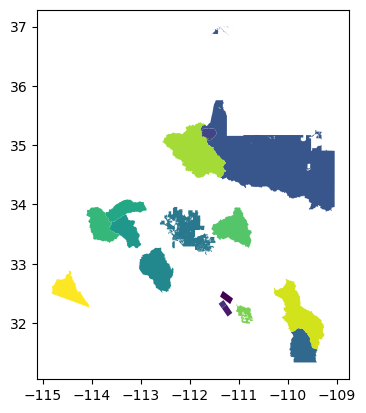

In [8]:
# Read in the shapefile

# filename_shapeile = 'georeg_reproject_fixed.shp'
filename_shapeile = 'AllCaseStudies.shp'
filepath = os.path.join(shapepath_local, filename_shapeile)
shapefile = gp.read_file(filepath)
shapefile.plot(cmap='viridis')


In [9]:
shapefile

,Name,FID,AMA_CODE,SUBBASIN_N,NAME_ABBR,SUBBASIN_1,SHAPEAREA,layer,path,geometry
0,GSF/USF,NaN,NaN,NaN,NaN,NaN,NaN,AvraValleyGSFUSF,/Users/danielletadych/Documents/PhD_Materials/...,"POLYGON Z ((-111.38373 32.44680 0.00000, -111...."
1,USF,NaN,NaN,NaN,NaN,NaN,NaN,AvraValleyGSFUSF,/Users/danielletadych/Documents/PhD_Materials/...,"POLYGON Z ((-111.34431 32.24769 0.00000, -111...."
2,Control,NaN,NaN,NaN,NaN,NaN,NaN,AvraValleyGSFUSF,/Users/danielletadych/Documents/PhD_Materials/...,"POLYGON Z ((-111.34573 32.24836 0.00000, -111...."
3,Flagstaff,14.00,NaN,NaN,NaN,NaN,NaN,Flagstaff_Buffered,/Users/danielletadych/Documents/PhD_Materials/...,"POLYGON Z ((-111.76613 35.19826 0.00000, -111...."
4,LittleCoR,NaN,A,JOSEPHCITY_LITTLECOR,JCI,JOSEPHCITYINA_LITTLECoR,69171676398.62,Little Co. River,/Users/danielletadych/Documents/PhD_Materials/...,"MULTIPOLYGON Z (((-109.04629 35.62503 0.00000,..."
5,Douglas,NaN,0,DOUGLAS,DOU,DOUGLAS,2458077525.61,DouglasAMA_updated,/Users/danielletadych/Documents/PhD_Materials/...,"POLYGON Z ((-109.61347 31.33412 0.00000, -109...."
6,Phoenix,78.00,NaN,NaN,NaN,NaN,NaN,Phoenix (Urban),/Users/danielletadych/Documents/PhD_Materials/...,"MULTIPOLYGON Z (((-112.40962 33.58074 0.00000,..."
7,GilaBend,NaN,0,GILA BEND,GIL,GILA BEND,3325765955.50,GilaBend,/Users/danielletadych/Documents/PhD_Materials/...,"POLYGON Z ((-112.58193 33.26550 0.00000, -112...."
8,Harquahala,NaN,G,HARQUAHALA,HAR,HARQUAHALA INA,1983266748.69,Harquahala,/Users/danielletadych/Documents/PhD_Materials/...,"POLYGON Z ((-113.30171 33.83493 0.00000, -113...."
9,McMullen,NaN,0,MCMULLEN VALLEY,MMU,MCMULLEN VALLEY,1680258416.27,McMullenValley,/Users/danielletadych/Documents/PhD_Materials/...,"POLYGON Z ((-113.38354 34.05454 0.00000, -113...."


In [69]:
# Define some things about your file

StudyArea = "Tucson and Phoenix (Urban)"
Naming_col = "Name"
water_designation = cap_secondary 

Merging the databases takes a little time - Approximately 0.1-3 minutes

In [11]:
# Merge the shapefile with the master database

shapefile = shapefile.to_crs(epsg=26912)
masterdb2 = masterdb.set_crs(epsg=26912)
masterdb_water = masterdb_water.set_crs(epsg=26912)
# For main static database
static_geo = gp.sjoin(masterdb2, shapefile, how="inner", op='intersects')

print(str(filename_mdb_nd) + " and " + str(filename_shapeile) + " join complete.")

# %% For the water wells water wells
static_geo2 = gp.sjoin(masterdb_water, shapefile, how="inner", op='intersects')
static_geo2.head()
print(str(filename_mdb_nd) + " and " + str(filename_shapeile) + " join complete.")


c:\Users\det19\.conda\envs\azgwspatialanalysis\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Master_ADWR_database_noduplicates.shp and AllCaseStudies.shp join complete.


c:\Users\det19\.conda\envs\azgwspatialanalysis\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Master_ADWR_database_noduplicates.shp and AllCaseStudies.shp join complete.


In [12]:
static_geo

,Combo_ID,SITE_ID,LOCAL_ID,REGISTRY_I,WELL_TYPE,DD_LAT,DD_LONG,WELL_ALT,WATER_USE_,WELL_DEPTH,...,index_right,Name,FID,AMA_CODE,SUBBASIN_N_right,NAME_ABBR,SUBBASIN_1,SHAPEAREA,layer,path
1,060001,334708112295301,B-05-02 08CCB,060001,INDEX,33.79,-112.50,1702.00,INDUSTRIAL,1000.00,...,6,Phoenix,78.00,NaN,NaN,NaN,NaN,NaN,Phoenix (Urban),/Users/danielletadych/Documents/PhD_Materials/...
52,084818,NaN,NaN,084818,NaN,NaN,NaN,NaN,NaN,810.00,...,6,Phoenix,78.00,NaN,NaN,NaN,NaN,NaN,Phoenix (Urban),/Users/danielletadych/Documents/PhD_Materials/...
75,084954,NaN,NaN,084954,NaN,NaN,NaN,NaN,NaN,280.00,...,6,Phoenix,78.00,NaN,NaN,NaN,NaN,NaN,Phoenix (Urban),/Users/danielletadych/Documents/PhD_Materials/...
122,085006,NaN,NaN,085006,NaN,NaN,NaN,NaN,NaN,0.00,...,6,Phoenix,78.00,NaN,NaN,NaN,NaN,NaN,Phoenix (Urban),/Users/danielletadych/Documents/PhD_Materials/...
123,085007,NaN,NaN,085007,NaN,NaN,NaN,NaN,NaN,600.00,...,6,Phoenix,78.00,NaN,NaN,NaN,NaN,NaN,Phoenix (Urban),/Users/danielletadych/Documents/PhD_Materials/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249633,928408,NaN,NaN,928408,NaN,NaN,NaN,NaN,NaN,220.00,...,3,Flagstaff,14.00,NaN,NaN,NaN,NaN,NaN,Flagstaff_Buffered,/Users/danielletadych/Documents/PhD_Materials/...
249838,928615,NaN,NaN,928615,NaN,NaN,NaN,NaN,NaN,240.00,...,3,Flagstaff,14.00,NaN,NaN,NaN,NaN,NaN,Flagstaff_Buffered,/Users/danielletadych/Documents/PhD_Materials/...
250184,928969,NaN,NaN,928969,NaN,NaN,NaN,NaN,NaN,280.00,...,3,Flagstaff,14.00,NaN,NaN,NaN,NaN,NaN,Flagstaff_Buffered,/Users/danielletadych/Documents/PhD_Materials/...
250831,929636,NaN,NaN,929636,NaN,NaN,NaN,NaN,NaN,NaN,...,3,Flagstaff,14.00,NaN,NaN,NaN,NaN,NaN,Flagstaff_Buffered,/Users/danielletadych/Documents/PhD_Materials/...


In [13]:
# Pull out the columns you need
# Use this or subbasins:
# reg_list = static_geo[['Combo_ID', Naming_col+'_right','WELL_DEPTH','WELL_TYPE_']]
# Use this or cities:
reg_list = static_geo[['Combo_ID', Naming_col,'WELL_DEPTH','WELL_TYPE_']]
reg_list

# %% Converting Combo_ID to int
reg_list['Combo_ID'] = reg_list['Combo_ID'].astype(np.int64, errors = 'raise')

C:\Users\det19\AppData\Local\Temp\ipykernel_13244\2831234236.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_list['Combo_ID'] = reg_list['Combo_ID'].astype(np.int64, errors = 'raise')


In [14]:
# Merging the Timeseries and the shapefile static database
combo = annual_db2.merge(reg_list, how="inner")
combo.info()

# %% set index to Combo_ID
combo.set_index('Combo_ID', inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Columns: 163 entries, Combo_ID to WELL_TYPE_
dtypes: float64(160), int64(1), object(2)
memory usage: 1.0+ MB


In [15]:
# Grouping the appropriate column
combo_copy = combo.copy()
combo_copy = combo_copy.drop(['WELL_DEPTH','WELL_TYPE_'],axis=1)
# cat_wl = combo_copy.groupby([Naming_col+"_right"]).mean()
cat_wl = combo_copy.groupby([Naming_col]).mean()

In [16]:
# Clean up the dataframe for graphing
cat_wl2 = cat_wl.copy()
i = cat_wl2
# del i['WELL_DEPTH']
f = i.transpose()
f.reset_index(inplace=True)
f['index'] = pd.to_numeric(f['index'])
f['index'] = f['index'].astype(int)
f.set_index('index', inplace=True)
f.info()
cat_wl2 = f
cat_wl2

<class 'pandas.core.frame.DataFrame'>
Index: 159 entries, 1853 to 2023
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Control        59 non-null     float64
 1   Douglas        77 non-null     float64
 2   Flagstaff      56 non-null     float64
 3   GSF/USF        83 non-null     float64
 4   GilaBend       75 non-null     float64
 5   Harquahala     70 non-null     float64
 6   LittleCoR      80 non-null     float64
 7   McMullen       72 non-null     float64
 8   Phoenix        91 non-null     float64
 9   RanegrasPlain  76 non-null     float64
 10  SaltRiver      40 non-null     float64
 11  Tucson         97 non-null     float64
 12  USF            74 non-null     float64
 13  Verde          70 non-null     float64
 14  Wilcox         80 non-null     float64
 15  Yuma           81 non-null     float64
dtypes: float64(16)
memory usage: 20.5 KB


Name,Control,Douglas,Flagstaff,GSF/USF,GilaBend,Harquahala,LittleCoR,McMullen,Phoenix,RanegrasPlain,SaltRiver,Tucson,USF,Verde,Wilcox,Yuma
index,,,,,,,,,,,,,,,,
1853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1864,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019,323.55,182.54,391.59,188.12,298.62,325.88,216.82,411.85,231.46,246.75,9.60,228.41,268.12,209.76,238.17,64.10
2020,323.77,188.87,392.92,187.69,342.60,367.32,226.70,427.41,232.73,260.36,5.50,234.33,274.52,207.85,255.31,62.19
2021,NaN,190.67,394.16,179.77,345.70,372.75,227.53,430.48,234.51,252.15,8.80,212.92,279.55,230.66,281.53,68.67


In [17]:
cat_wl2.head(-1)

Name,Control,Douglas,Flagstaff,GSF/USF,GilaBend,Harquahala,LittleCoR,McMullen,Phoenix,RanegrasPlain,SaltRiver,Tucson,USF,Verde,Wilcox,Yuma
index,,,,,,,,,,,,,,,,
1853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1864,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018,329.89,197.08,366.31,192.36,303.04,329.15,217.55,414.71,246.26,253.88,13.80,230.18,255.90,211.79,259.42,65.47
2019,323.55,182.54,391.59,188.12,298.62,325.88,216.82,411.85,231.46,246.75,9.60,228.41,268.12,209.76,238.17,64.10
2020,323.77,188.87,392.92,187.69,342.60,367.32,226.70,427.41,232.73,260.36,5.50,234.33,274.52,207.85,255.31,62.19


In [18]:
# Export the dataframe
# cat_wl2_reg.to_csv(outputpath_local+'Waterlevels_Regulation_updated_thresh15outliersdeleted.csv')

### Analysis and Graphing

In [19]:
# Read in the drought indices
# drought_indices = pd.read_csv(datapath+'Yearly_DroughtIndices.csv')
drought_indices = pd.read_csv(inputpath_local+'/Yearly_DroughtIndices_updated12032023.csv') #this version doesn't have PHDI so adjust accordingly
drought_indices = drought_indices.set_index('In_year')
# drought_indices

In [20]:
Min_year_of_Study = 2000

# Water Analysis period
wlanalysis_period = cat_wl2[(cat_wl2.index>=Min_year_of_Study)&(cat_wl2.index<=2022)]
drought_indices = drought_indices[(drought_indices.index>=Min_year_of_Study)&(drought_indices.index<=2022)]
# del wlanalysis_period['Res'] # Only run this if doing regulation shapefile
wlanalysis_period.head()

Name,Control,Douglas,Flagstaff,GSF/USF,GilaBend,Harquahala,LittleCoR,McMullen,Phoenix,RanegrasPlain,SaltRiver,Tucson,USF,Verde,Wilcox,Yuma
index,,,,,,,,,,,,,,,,
2000,365.48,153.19,228.65,230.05,206.10,345.45,270.66,394.27,266.79,218.20,11.60,261.14,380.37,241.87,226.35,57.05
2001,360.80,NaN,344.36,225.29,213.93,340.25,271.80,410.20,243.33,194.17,11.94,233.79,385.27,222.92,226.70,76.49
2002,358.92,150.16,244.00,220.37,222.67,355.18,277.70,391.88,248.61,220.15,13.34,264.70,401.43,190.28,219.70,48.99
2003,358.39,157.44,226.62,208.78,232.34,339.23,287.20,409.60,258.59,230.36,13.59,253.96,399.11,199.98,226.31,50.26
2004,352.46,158.20,227.84,203.33,239.06,347.80,285.63,424.97,244.22,241.20,12.86,258.13,400.58,210.48,220.62,51.22


This is helpful if you're missing values and it won't calculate statistics

In [73]:
df_interpolated = wlanalysis_period.interpolate(method='linear', axis=0)
df_interpolated

Name,Control,Douglas,Flagstaff,GSF/USF,GilaBend,Harquahala,LittleCoR,McMullen,Phoenix,RanegrasPlain,SaltRiver,Tucson,USF,Verde,Wilcox,Yuma
index,,,,,,,,,,,,,,,,
2000,365.48,153.19,228.65,230.05,206.10,345.45,270.66,394.27,266.79,218.20,11.60,261.14,380.37,241.87,226.35,57.05
2001,360.80,151.68,344.36,225.29,213.93,340.25,271.80,410.20,243.33,194.17,11.94,233.79,385.27,222.92,226.70,76.49
2002,358.92,150.16,244.00,220.37,222.67,355.18,277.70,391.88,248.61,220.15,13.34,264.70,401.43,190.28,219.70,48.99
2003,358.39,157.44,226.62,208.78,232.34,339.23,287.20,409.60,258.59,230.36,13.59,253.96,399.11,199.98,226.31,50.26
2004,352.46,158.20,227.84,203.33,239.06,347.80,285.63,424.97,244.22,241.20,12.86,258.13,400.58,210.48,220.62,51.22
2005,355.26,153.11,215.10,200.56,211.27,338.76,297.27,402.19,261.03,234.60,10.59,249.63,404.46,198.24,215.20,52.12
2006,351.20,158.01,217.40,196.25,235.45,341.33,284.69,412.82,256.38,232.93,10.78,242.43,397.65,200.26,243.82,53.48
2007,328.66,162.29,224.03,190.43,251.47,338.57,222.76,405.92,251.28,231.53,11.48,259.99,392.86,193.69,212.47,60.73
2008,353.90,181.19,373.43,188.03,260.75,288.41,180.41,423.81,232.89,214.39,9.91,251.79,390.75,177.77,185.72,52.40


In [78]:
StudyArea = 'Verde and Gila Bend'

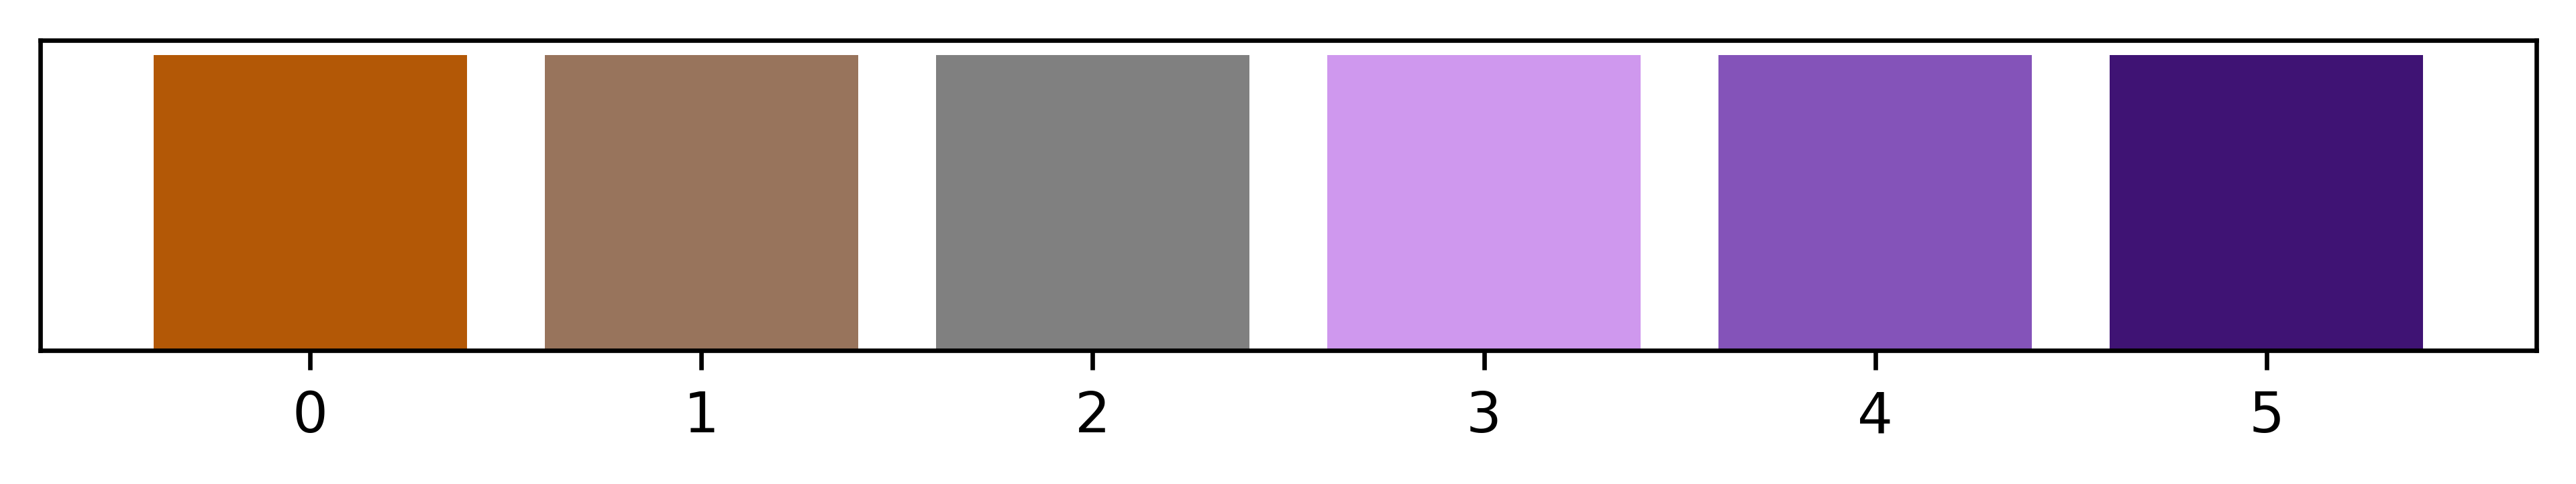

In [81]:
# This is to delete some columns as needed
columns_to_delete = ['Control','GSF/USF','Harquahala','SaltRiver',
                     'USF','Douglas'
                    #  ,'Verde','GilaBend'
                     ,'Tucson','Phoenix'
                     ,'McMullen','RanegrasPlain'
                     ,'Flagstaff'
                     ,'LittleCoR','Yuma','Wilcox']
df = df_interpolated.drop(columns=columns_to_delete)
# colors_to_delete=[blind[0],blind[3],blind[4],blind[7],blind[8],blind[9],blind[13],blind[14]]
# refined_blind_colors = blind.copy()
# for color in colors_to_delete:
#     refined_blind_colors.remove(color)
# refined_blind_colors.reverse()
# refined_blind_colors
# refined_blind_colors = ['#332288', '#166C98', '#44AA99', '#117733', '#C3B050', '#B83E23', '#882255', '#AA4499']

# Orange / Purple
# refined_blind_colors = ["#b35806","#f1a340",'#98745c','#808080','#d8daeb','#998ec3','#542788']
# refined_blind_colors = ['#b35806', '#a86638', '#98745c', '#808080', '#cf98ee', '#8453b9', '#3f1374']
refined_blind_colors = ['#b35806', '#98745c', '#808080', '#cf98ee', '#8453b9', '#3f1374']

# Dark Red / Blue
# refined_blind_colors = ['#00429d', '#3a64ac', '#5a88ba', '#a6a6a6', '#d55f71', '#c12550', '#93003a']

# Blue Red
# refined_blind_colors = ['#00429d', '#495594', '#686a8b', '#808080', '#f89672', '#bf452b', '#6e0000']
# refined_blind_colors.reverse()

# Create a bar plot to visualize colors
fig, ax = plt.subplots(figsize=(8, 1))
ax.bar(range(len(refined_blind_colors)), height=1, color=refined_blind_colors)

# Remove y-axis
ax.set_yticks([])

# Show the plot
plt.show()

          slope       int  rsq  p_val  std_err   mean     var     sum
GilaBend   5.76 -11314.33 0.88   0.00     0.46 268.72 1651.81 6180.59
Verde      0.16   -118.02 0.01   0.75     0.49 203.76  221.93 4686.58


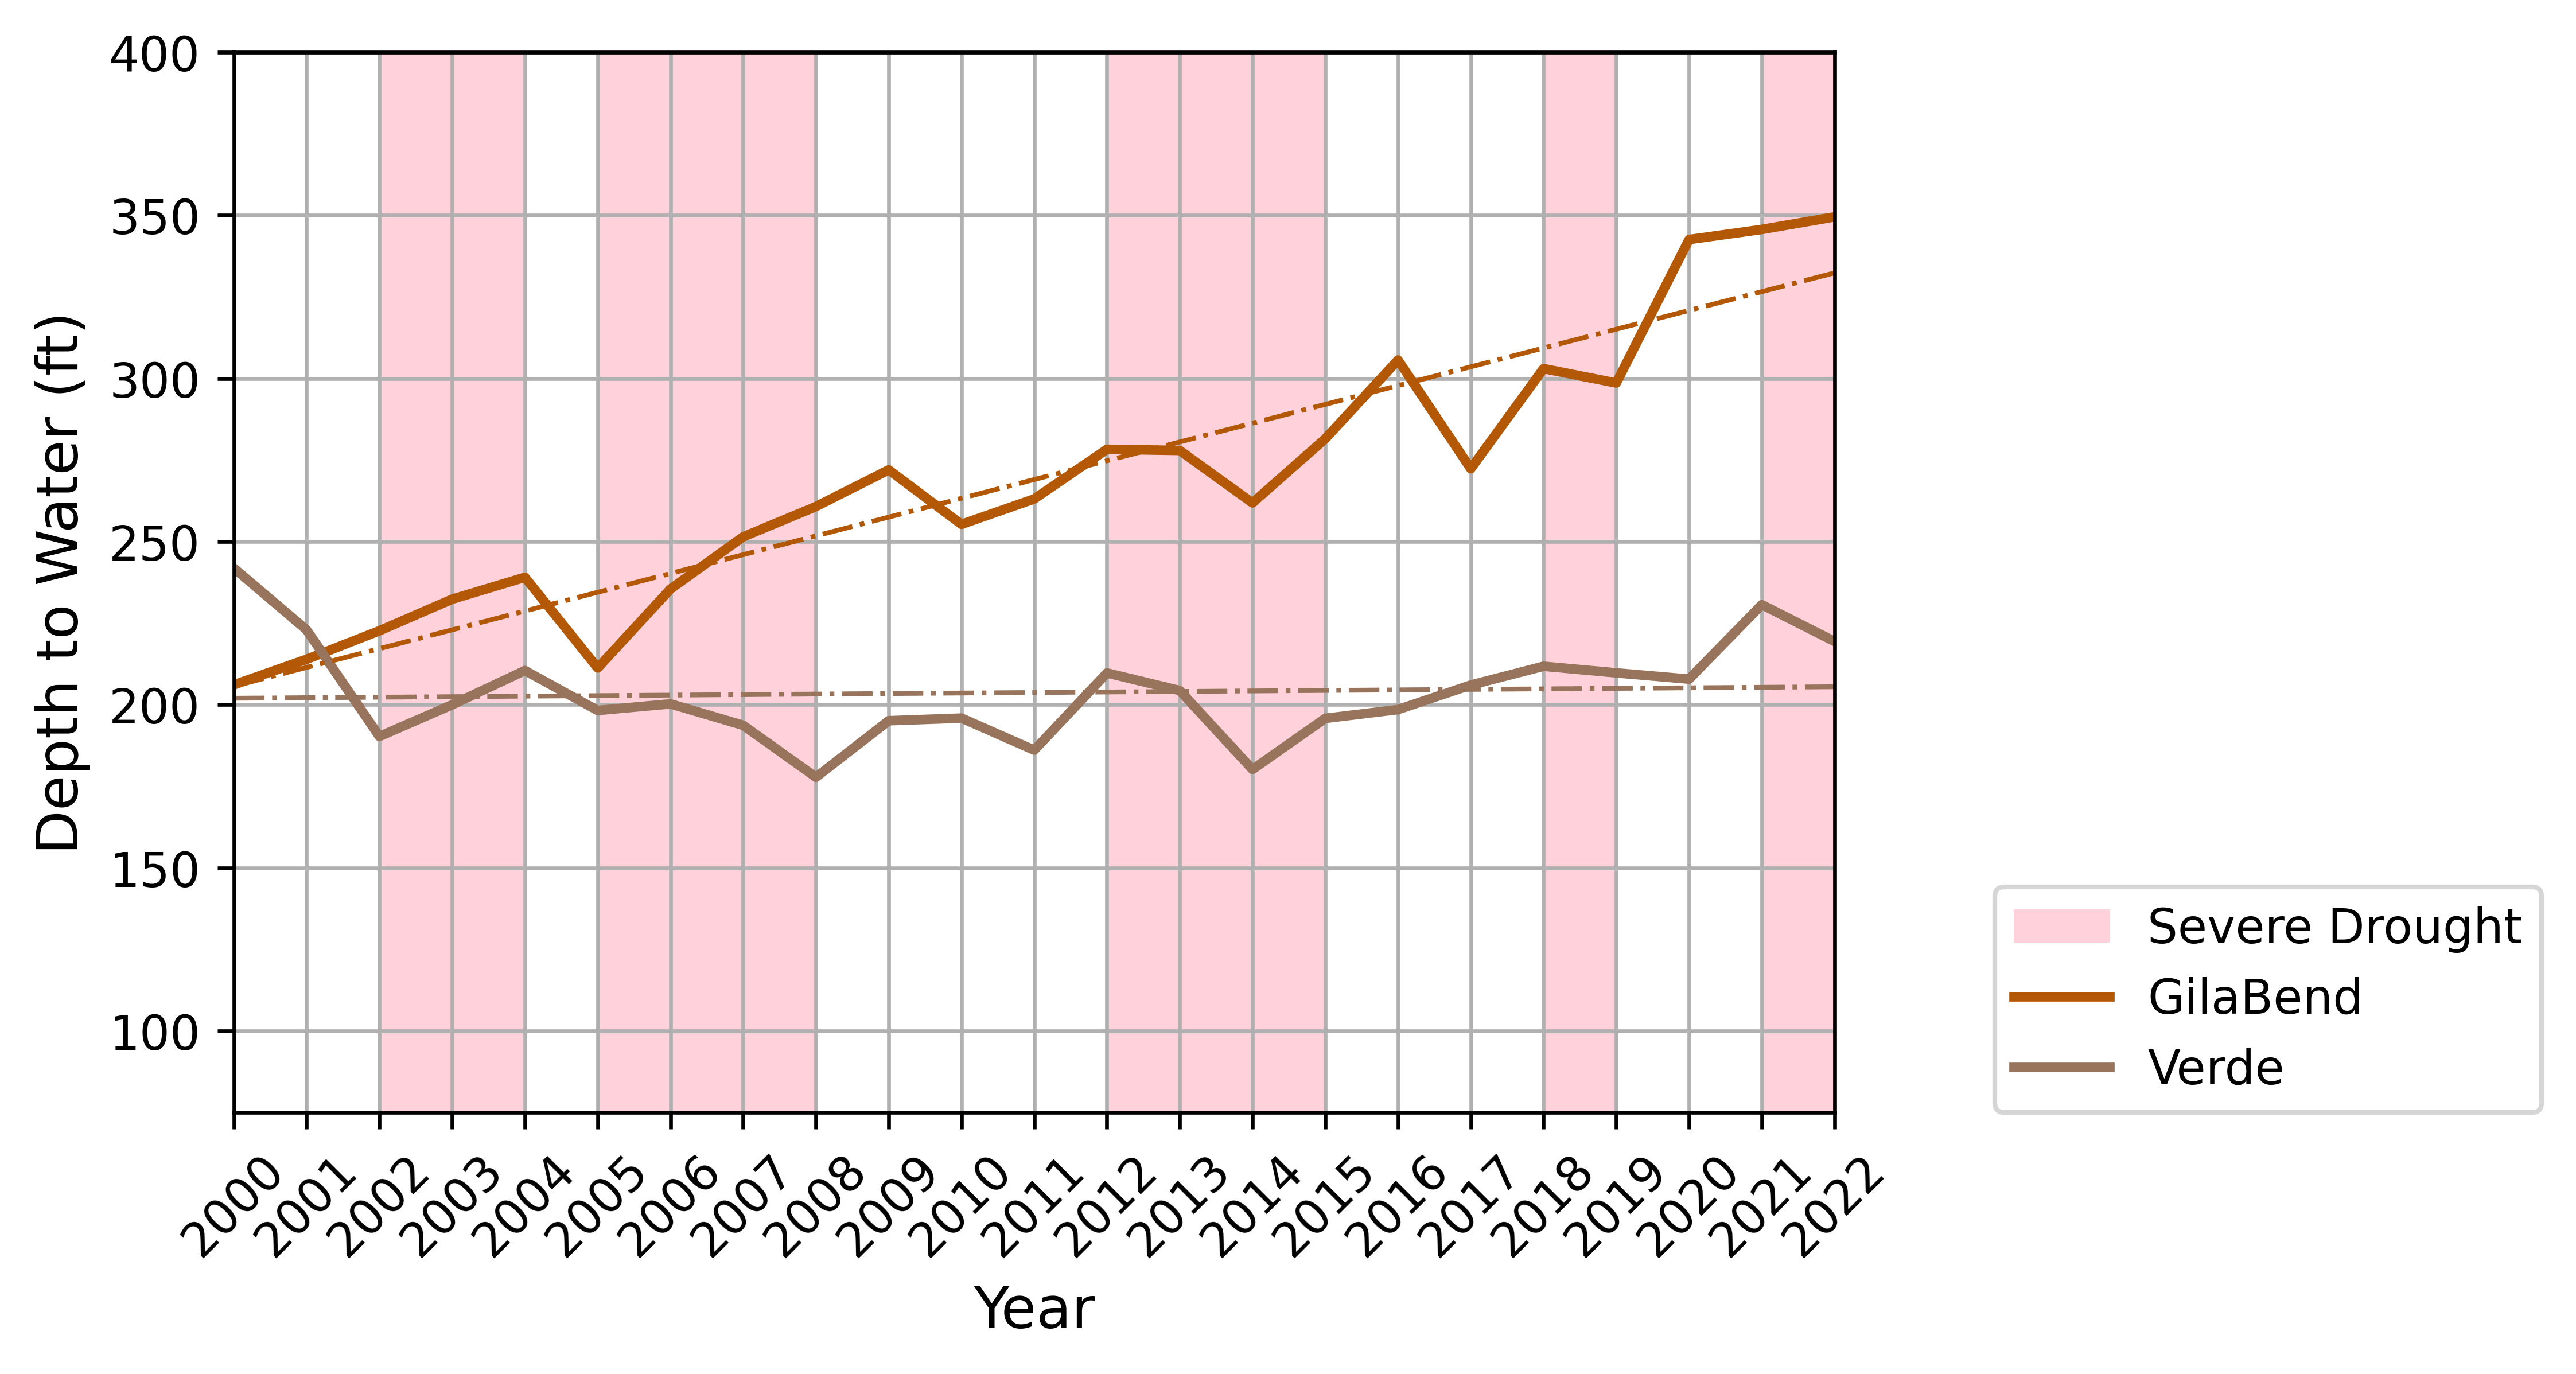

In [82]:
# For Depth to Water for all Case Studies
# ds = wlanalysis_period
ds = df
min_yr = 2000
mx_yr = 2022
Name = "mean_"+StudyArea
betterlabels = ds.columns.tolist()

f = ds[(ds.index >= min_yr) & (ds.index <= mx_yr)]
columns = ds.columns
column_list = ds.columns.tolist()

stats = pd.DataFrame()
# for i in range(1, 12, 1):
for i in column_list:
        df = f[i]
        #print(df)
        y=np.array(df.values, dtype=float)
        x=np.array(pd.to_datetime(df).index.values, dtype=float)
        slope, intercept, r_value, p_value, std_err =sp.linregress(x,y)
        stats = stats._append({'slope': slope, 
                              'int':intercept, 
                              'rsq':r_value*r_value, 
                              'p_val':p_value, 
                              'std_err':std_err, 
                              'mean': np.mean(y),
                              'var': np.var(y),
                              'sum': np.sum(y)
                              },
                              ignore_index=True)


stats.index = betterlabels
stats = stats.sort_values(by='slope', ascending=False)
stats1 = stats.transpose()
print(stats)
stats.to_csv(outputpath_local+'Stats_'+StudyArea+'.csv')

# -- Data visualization --

fig, ax = plt.subplots(1, 1, figsize = (6,4))

min_y = 75
max_y = 400
fsize = 12

num_years = mx_yr - min_yr + 1
ax.set_xticks(np.linspace(min_yr, mx_yr, num_years))
ax.set_xticklabels(map(int, ax.get_xticks()))

# Drought Year Shading
a = 1988
b = 1990
c = 1995
d = 1996
e = 2021
f = 2022
g = 2002
h = 2004
i = 2005
j = 2008
k = 2012
l = 2015
m = 2018
n = 2019
plt.axvspan(a, b, color=drought_color, alpha=0.5, lw=0
            , label="Severe Drought"
            )
plt.axvspan(c, d, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(e, f, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(g, h, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(i, j, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(k, l, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(m, n, color=drought_color, alpha=0.5, lw=0)

# Plotting the data
for i,j in zip(stats1.columns,refined_blind_colors):
        ax.plot(ds[i],color=j, label=str(i),lw=2)
# ax.plot(ds[column_list[0]], color=water_designation)
# ax.plot(ds[column_list[0]], color=blind[1],label=betterlabels[0]) 
# ax.plot(ds[column_list[1]], color=blind[2],label=betterlabels[1]) 
# ax.plot(ds[column_list[2]], color=blind[6],label=betterlabels[2])  
xf = np.linspace(min(x),max(x),100)
xf1 = xf.copy()

# Plotting Trendlines
for i,j in zip(stats1.columns,refined_blind_colors):
        #xf1 = pd.to_datetime(xf1)
        m1 = round(stats1.loc['slope',i], 2)
        yint1 = round(stats1.loc['int',i], 2)
        pval1 = round(stats1.loc['p_val',i], 4)
        yf1 = (m1*xf)+yint1
        # ax.plot(xf1, yf1,"-.",color=blind[j], lw=1)
        ax.plot(xf1, yf1,"-.",color=j, lw=1)

ax.set_xlim(min_yr,mx_yr)
ax.set_ylim(min_y,max_y)
# ax.grid(True)
ax.grid(visible=True,which='major')
ax.grid(which='minor',color='#EEEEEE', lw=0.8)
ax.set_xlabel('Year', fontsize=fsize)
ax.set_ylabel('Depth to Water (ft)',fontsize=fsize)
# ax.minorticks_on()
ax.tick_params(axis='x', rotation=45)
fig.set_dpi(600.0)
# ax.set_title('a)',loc='left',pad=15)
# ax.legend(loc='upper right')
ax.legend(loc=[1.1,0])


plt.savefig(figurepath+Name, bbox_inches = 'tight')

In [83]:
# Anomaly's
# Need to redo this line for some reason
df = df_interpolated.drop(columns=columns_to_delete)
# ds = wlanalysis_period.copy()
# ds = df_interpolated.copy()
ds = df.copy()
# columns = ds.columns
column_list = df.columns.tolist()
# trend_df = wlanalysis_period.copy()
# trend_df = df_interpolated.copy()
trend_df = df.copy()
dtw_anomalys = pd.DataFrame()
for i in column_list:
        # Subtracting against the mean
        # dtw_anomalys[i] = wlanalysis_period[i] - wlanalysis_period[i].mean()
        
        # Subtracting against the slope
        dataframe = ds[i]
        y=np.array(dataframe.values, dtype=float)
        x=np.array(pd.to_datetime(dataframe).index.values, dtype=float)
        slope, intercept, r_value, p_value, std_err = sp.linregress(x,y)
        # print(y)
        # slope, intercept = sp.linregress(x,y) 
        # trend_df[i] = (wlanalysis_period.index*slope) + intercept
        # dtw_anomalys[i] = wlanalysis_period[i] - trend_df[i]
        # trend_df[i] = (df_interpolated.index*slope) + intercept
        # dtw_anomalys[i] = df_interpolated[i] - trend_df[i]
        trend_df[i] = (df.index*slope) + intercept
        dtw_anomalys[i] = df[i] - trend_df[i]

dtw_anomalys.head()

,GilaBend,Verde
index,,
2000,0.74,39.86
2001,2.81,20.75
2002,5.79,-12.05
2003,9.70,-2.51
2004,10.66,7.83


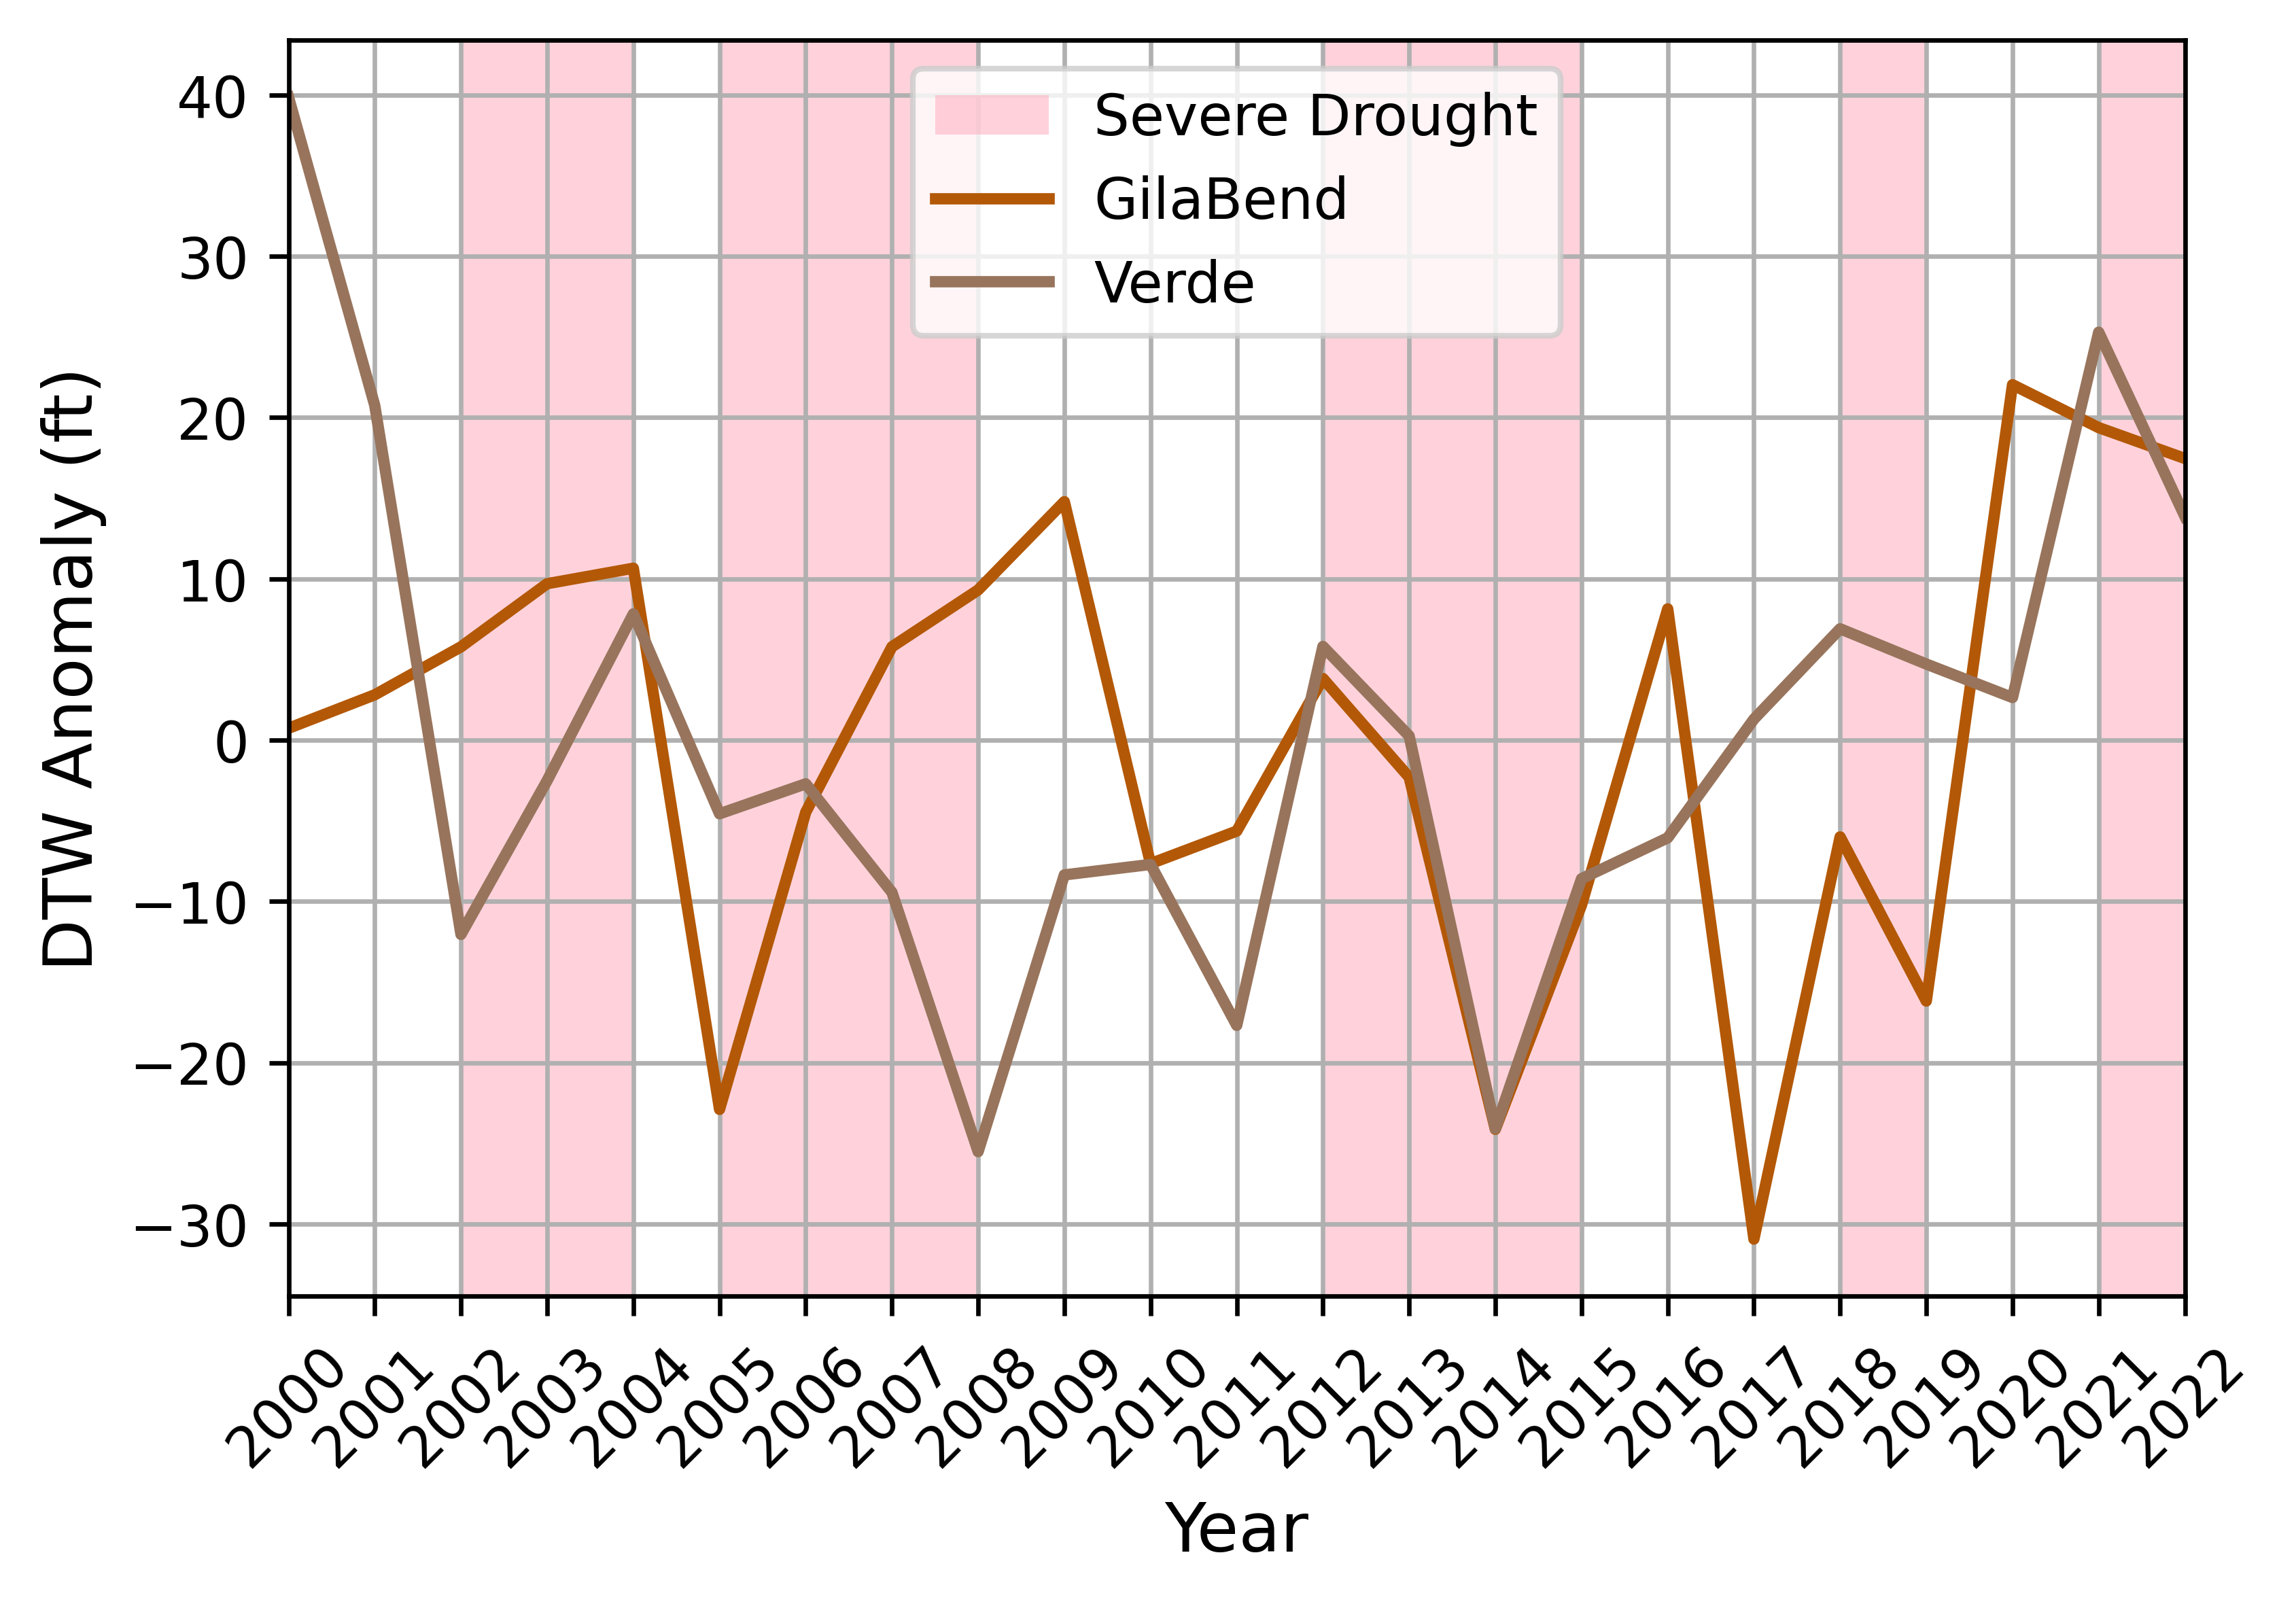

In [85]:
# For Depth to Water by regulation
ds = dtw_anomalys
min_yr = 2000
mx_yr = 2022

columns = ds.columns
column_list = ds.columns.tolist()

fig, ax = plt.subplots(1, 1, figsize = (6,4))

min_y = -12
max_y = 15
fsize = 12
num_years = mx_yr - min_yr + 1
ax.set_xticks(np.linspace(min_yr, mx_yr, num_years))
ax.set_xticklabels(map(int, ax.get_xticks()))

# Drought Year Shading
a = 1988
b = 1990
c = 1995
d = 1996
e = 2021
f = 2022
g = 2002
h = 2004
i = 2005
j = 2008
k = 2012
l = 2015
m = 2018
n = 2019
plt.axvspan(a, b, color=drought_color, alpha=0.5, lw=0, label="Severe Drought")
plt.axvspan(c, d, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(e, f, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(g, h, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(i, j, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(k, l, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(m, n, color=drought_color, alpha=0.5, lw=0)

for i,j in zip(ds.columns,refined_blind_colors):
        ax.plot(ds[i],color=j, label=str(i),lw=2)
# ax.plot(ds[column_list[0]], color=water_designation, lw=1.5)
# ax.plot(ds[column_list[0]], color=blind[1],label=betterlabels[0]) 
# ax.plot(ds[column_list[1]], color=blind[2],label=betterlabels[1]) 
# ax.plot(ds[column_list[2]], color=blind[6],label=betterlabels[2])  

ax.set_xlim(min_yr,mx_yr)
# ax.set_ylim(min_y,max_y)
# ax.grid(True)
ax.grid(visible=True,which='major')
ax.grid(which='minor',color='#EEEEEE', lw=0.8)
ax.set_xlabel('Year', fontsize=fsize)
ax.set_ylabel('DTW Anomaly (ft)',fontsize=fsize)
# ax.minorticks_on()
ax.tick_params(axis='x', rotation=45)
fig.set_dpi(600.0)
# ax.set_title('a)',loc='left',pad=15)
ax.legend(loc='upper center')

#Putting Grace on a secondary axis
# ax2 = ax.twinx()
# ax2.plot(grace_yearly['0'], label='State Average LWE', color='k',zorder=1)
# ax2.set_ylim([15, -15])
# ax2.set_ylabel(u'Δ LWE (cm)',fontsize=fsize)
# ax2.legend(loc='lower right')

plt.savefig(figurepath+'Timeseries of DTW Anomalies for '+StudyArea, bbox_inches = 'tight')

Calculating Max Drawdown (maximum anomaly in the drought period)

In [86]:
# %% Average Anomalie for drought periods
ds = dtw_anomalys.copy()
columns = ds.columns
column_list = ds.columns.tolist()

ds['Status'] = 'Normal-Wet'
# wlanalysis_period

for x,y in DROUGHT_YEARS.items():
        ds.loc[y, 'Status'] = 'Drought '+str(x)


dtw_max_anomalies = ds.groupby(['Status']).max()
dtw_max_anomalies
# ds

,GilaBend,Verde
Status,,
Drought 3,9.70,-2.51
Drought 4,5.79,-2.71
Drought 5,3.82,5.81
Drought 6,-6.00,6.91
Drought 7,19.38,25.30
Normal-Wet,22.04,39.86


In [87]:
# Reorder the dataframe

test = pd.DataFrame()
test['Gila Bend'] = dtw_max_anomalies['GilaBend']
test['Verde'] = dtw_max_anomalies['Verde']
# test['Wilcox'] = dtw_max_anomalies['Wilcox']
# test['Yuma'] = dtw_max_anomalies['Yuma']
# test['Phoenix'] = dtw_max_anomalies['Phoenix']
# test['Tucson'] = dtw_max_anomalies['Tucson']
# test['Little Colorado \nRiver Basin'] = dtw_max_anomalies['LittleCoR']
test

,Gila Bend,Verde
Status,,
Drought 3,9.70,-2.51
Drought 4,5.79,-2.71
Drought 5,3.82,5.81
Drought 6,-6.00,6.91
Drought 7,19.38,25.30
Normal-Wet,22.04,39.86


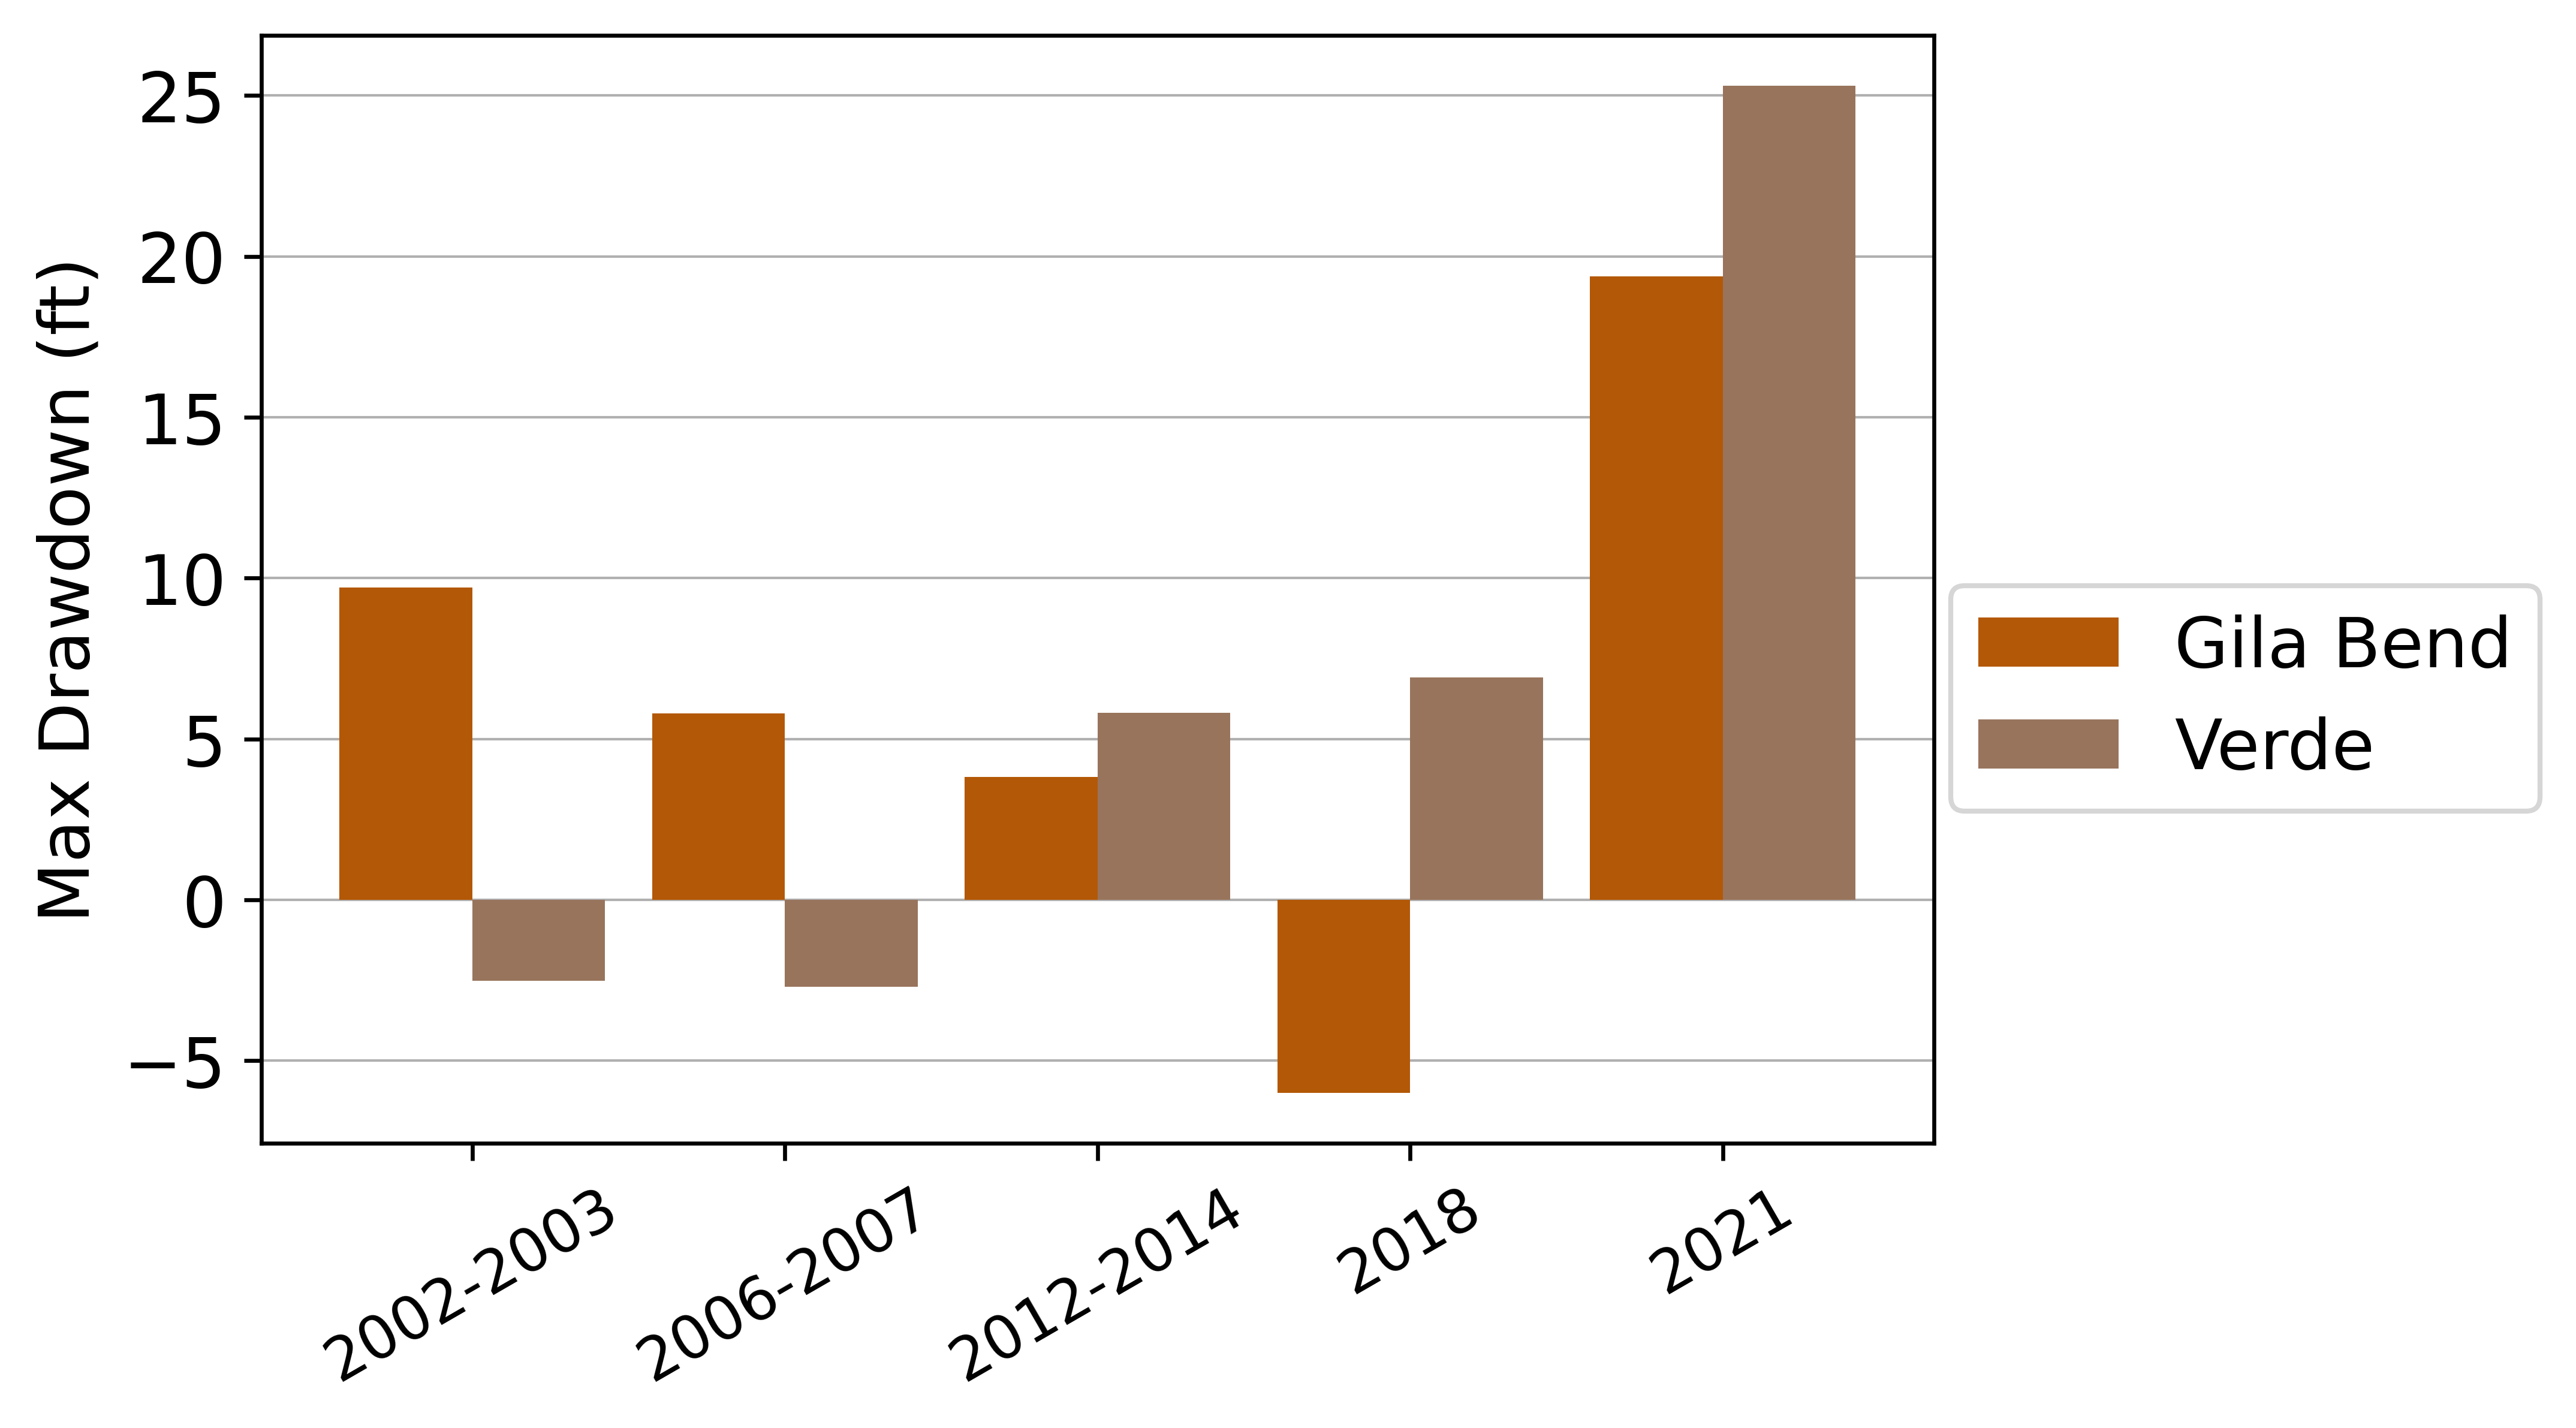

In [88]:
#%% Grouped Bar chart for drawdown (ft)
# name = 'Average DTW Anomalies by Drought Period and Groundwater Regulation'
name = 'Max Drawdown by Drought Period for '+StudyArea

# ds = dtw_max_anomalies
ds = test

yearlabels = [
                # "1989-1990"
        #       ,'1996',
              '2002-2003','2006-2007','2012-2014','2018','2021'
              ,'Normal/Wet Years'
        ]
# betterlabels = ['CAP','Regulated \n Groundwater','Surface \n Water','Unregulated \n Groundwater','Mixed \n GW/SW'] 
# betterlabels = [StudyArea]
betterlabels = ds.columns.tolist()

ds.index = yearlabels
ds = ds.transpose()

ds.index = betterlabels
del ds['Normal/Wet Years']
ds = ds.transpose()


# group_colors = ['lightsalmon','tomato','orangered','r','brown','indianred','steelblue']

# group_colors = [blind[0],blind[2],blind[6]
#                 ,blind[12],blind[11],blind[10]
#                 # ,blind[0] #black
                # ]
group_colors = [water_designation]

# horlabel = 'DTW Anomaly (ft)'
horlabel = 'Max Drawdown (ft)'
fsize = 14

plt.rcParams["figure.dpi"] = 600
ds.plot(figsize = (6,4),
        kind='bar',
        stacked=False,
        # title=name,
        # color = group_colors,
        color = refined_blind_colors,
        zorder = 2,
        width = 0.85,
        fontsize = fsize
        )
# plt.title(name, fontsize = (fsize+2))
# plt.ylim([-40,40])
plt.ylabel(horlabel, fontsize = fsize)
plt.xticks(rotation=30, fontsize = fsize-2)
plt.grid(axis='y', linewidth=0.5, zorder=0)
plt.legend(loc=[1.01,0.3],fontsize = fsize)
# plt.set_dpi(600)

plt.savefig(figurepath+name+'_anomalies_groupedchart', bbox_inches = 'tight')

In [93]:
# New wells

static_geo2['INSTALLED'] = pd.to_datetime(static_geo2['INSTALLED'])
# static_geo2['INSTALLED'].describe()

static_geo2['In_year'] = static_geo2['INSTALLED'].dt.year
# new_wells = pd.pivot_table(static_geo2, index=["In_year"], columns=[Naming_col+"_right"], values=["INSTALLED"], dropna=False, aggfunc=len)
new_wells = pd.pivot_table(static_geo2, index=["In_year"], columns=[Naming_col], values=["INSTALLED"], dropna=False, aggfunc=len)
# new_wells = new_wells.reset_index()

new_wells.to_csv(outputpath_local+'Final_NewWells_'+StudyArea+'.csv')

In [94]:
# To get it formatted correctly
all_columns = wlanalysis_period.columns.tolist()
new_wells2 = pd.read_csv(outputpath_local+'Final_NewWells_'+StudyArea+'.csv',
                        header=2,
                        # names = ['R','Res','U']
                        names = all_columns
                        # names = [StudyArea]
                        , index_col=0
                        )
new_wells2

,Control,Douglas,Flagstaff,GSF/USF,GilaBend,Harquahala,LittleCoR,McMullen,Phoenix,RanegrasPlain,SaltRiver,Tucson,USF,Verde,Wilcox,Yuma
1900.00,NaN,1.00,1.00,NaN,NaN,NaN,NaN,NaN,1.00,NaN,NaN,NaN,NaN,NaN,1.00,NaN
1910.00,NaN,NaN,NaN,NaN,NaN,NaN,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1915.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,NaN,NaN,NaN,NaN
1916.00,NaN,NaN,NaN,NaN,NaN,NaN,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1917.00,NaN,NaN,NaN,NaN,NaN,NaN,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019.00,NaN,16.00,6.00,3.00,18.00,1.00,41.00,6.00,63.00,7.00,15.00,10.00,NaN,17.00,103.00,17.00
2020.00,NaN,19.00,11.00,4.00,2.00,4.00,88.00,10.00,60.00,5.00,10.00,27.00,NaN,38.00,72.00,40.00
2021.00,3.00,27.00,11.00,1.00,2.00,1.00,73.00,9.00,47.00,5.00,29.00,17.00,2.00,28.00,66.00,75.00
2022.00,1.00,24.00,13.00,3.00,1.00,2.00,64.00,7.00,53.00,6.00,5.00,21.00,NaN,21.00,71.00,32.00


In [95]:
new_wells2 = new_wells2.drop(columns=columns_to_delete)
new_wells2.to_csv(outputpath_local+'Final_NewWells_'+StudyArea+'.csv')
new_wells2

,GilaBend,Verde
1900.00,NaN,NaN
1910.00,NaN,NaN
1915.00,NaN,NaN
1916.00,NaN,NaN
1917.00,NaN,NaN
...,...,...
2019.00,18.00,17.00
2020.00,2.00,38.00
2021.00,2.00,28.00
2022.00,1.00,21.00


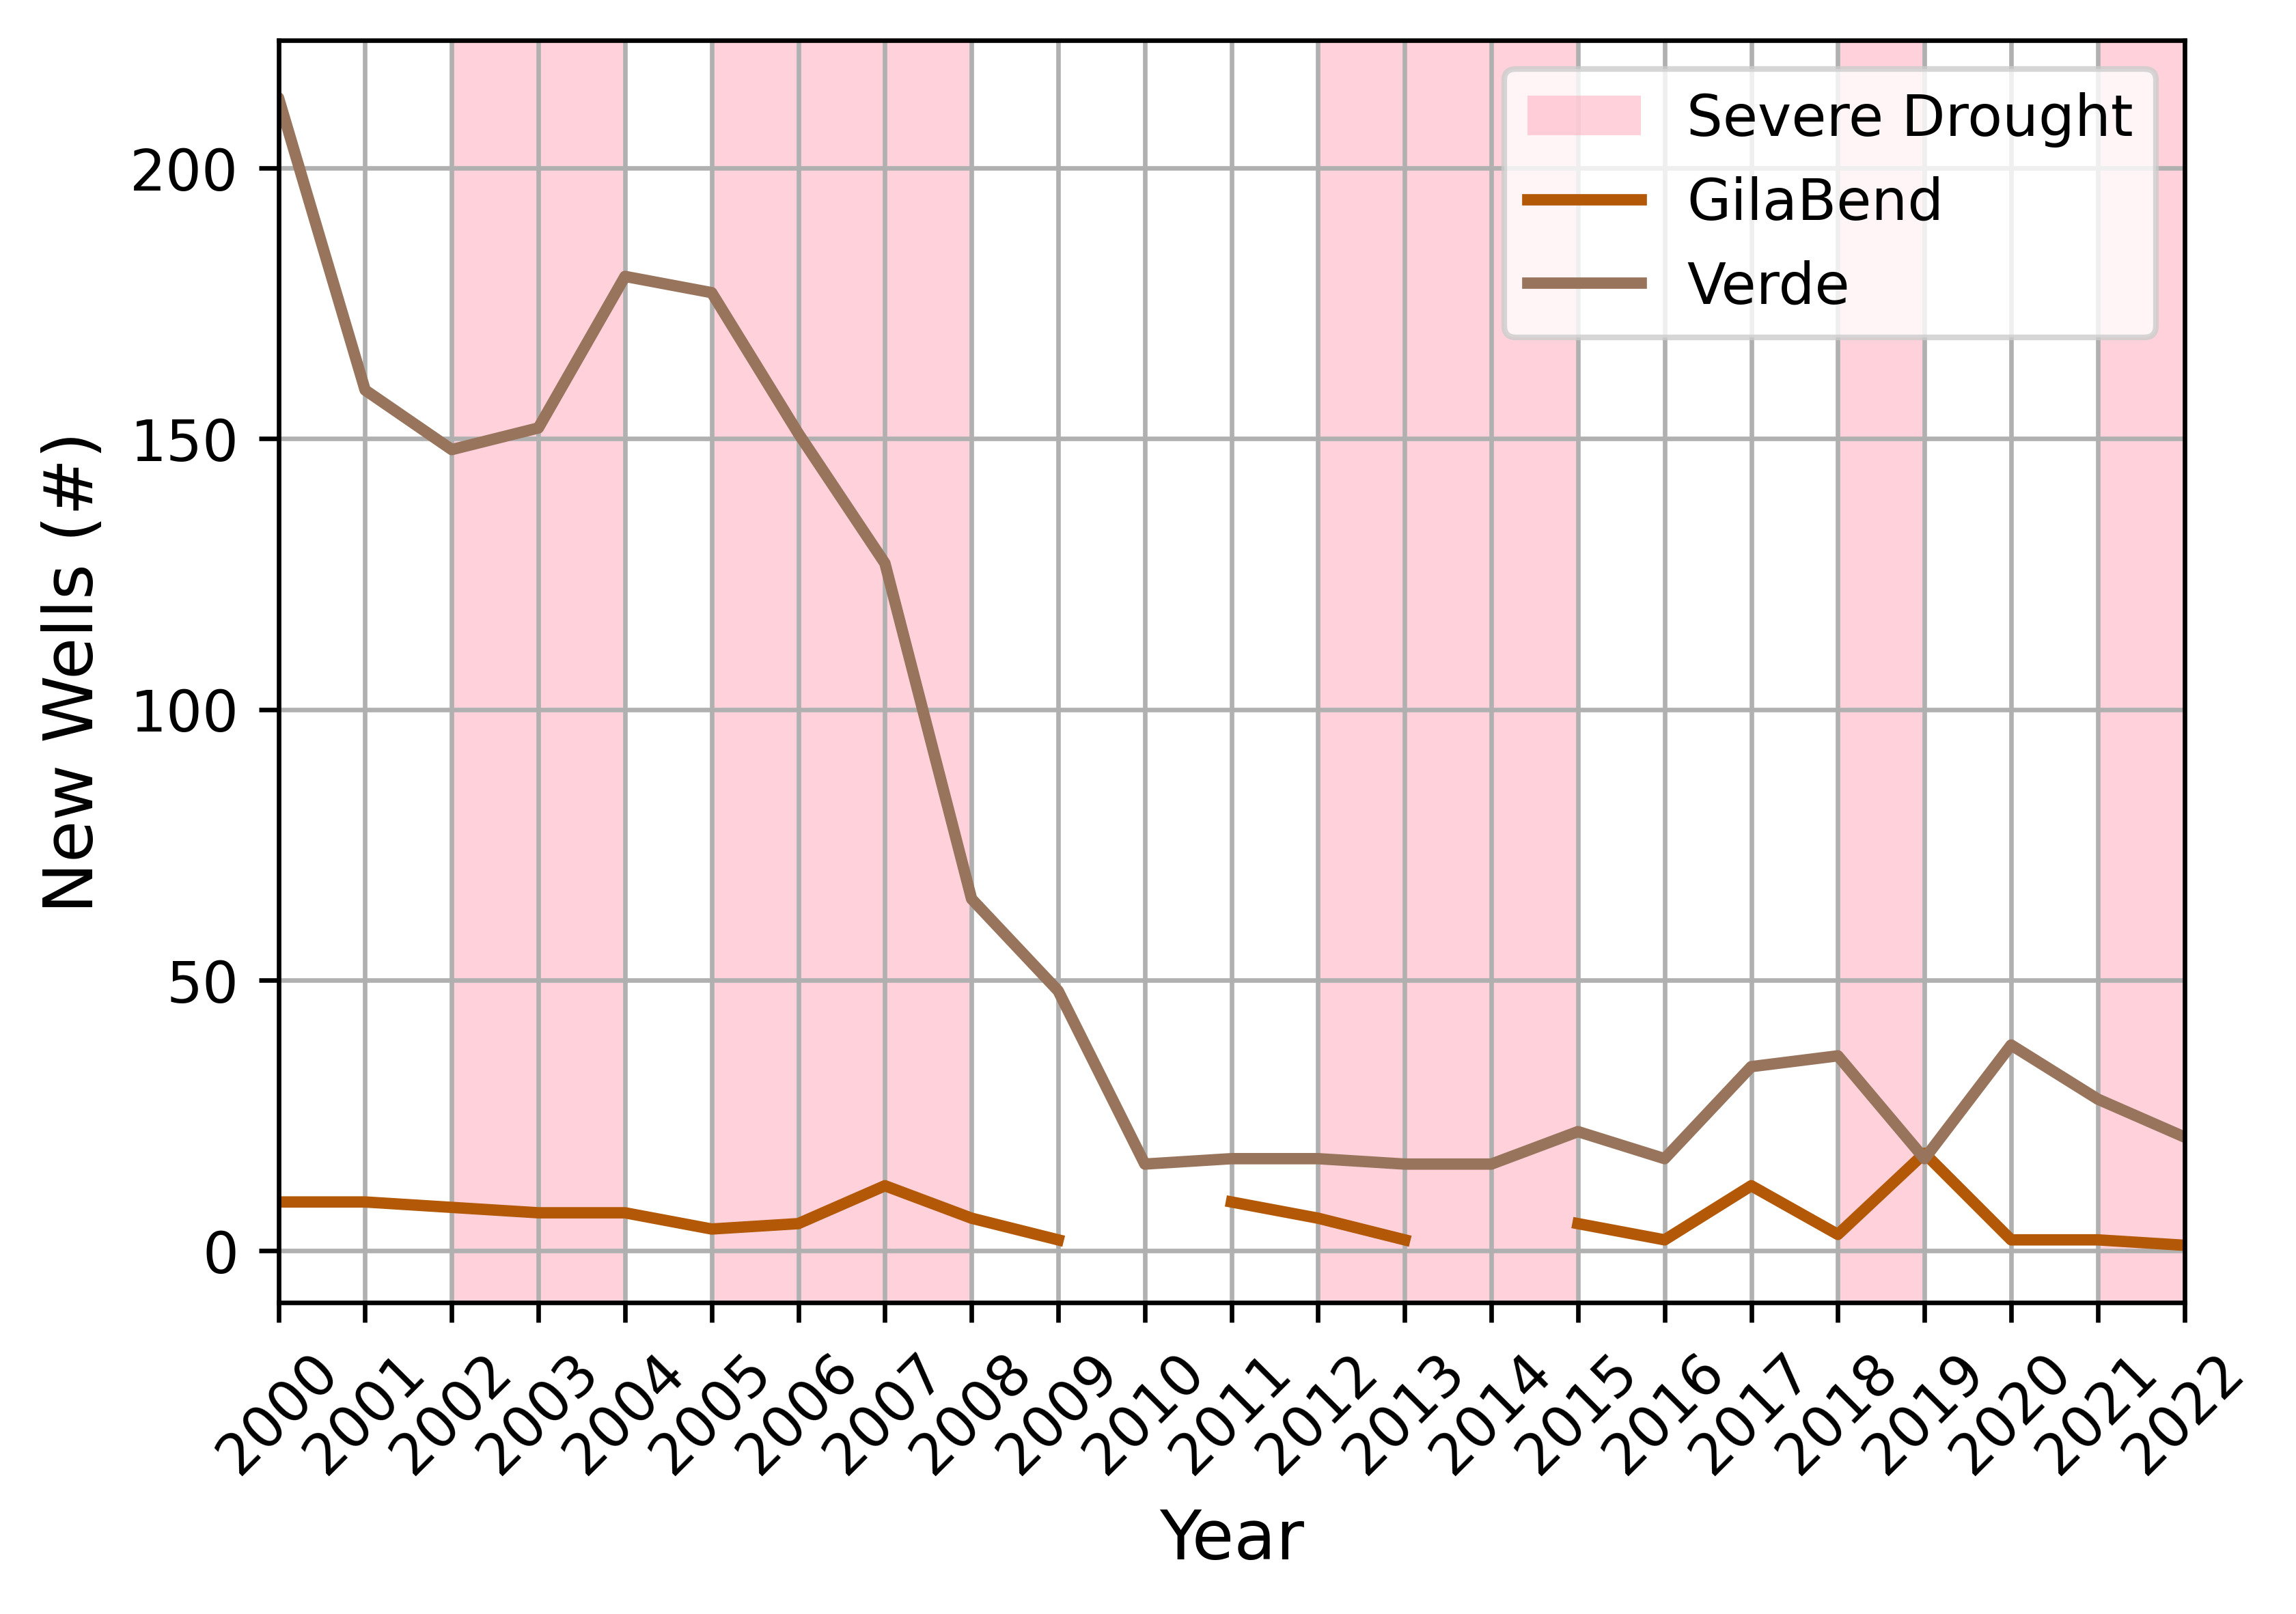

In [96]:

# For Depth to Water by regulation
ds = new_wells2
min_yr = 2000
mx_yr = 2022
# betterlabels = ['Regulated','Unregulated']

columns = ds.columns
column_list = ds.columns.tolist()

fig, ax = plt.subplots(1, 1, figsize = (6,4))

min_y = -12
max_y = 15
fsize = 12
num_years = mx_yr - min_yr + 1
ax.set_xticks(np.linspace(min_yr, mx_yr, num_years))
ax.set_xticklabels(map(int, ax.get_xticks()))

# Drought Year Shading
a = 1988
b = 1990
c = 1995
d = 1996
e = 2021
f = 2022
g = 2002
h = 2004
i = 2005
j = 2008
k = 2012
l = 2015
m = 2018
n = 2019
plt.axvspan(a, b, color=drought_color, alpha=0.5, lw=0, label="Severe Drought")
plt.axvspan(c, d, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(e, f, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(g, h, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(i, j, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(k, l, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(m, n, color=drought_color, alpha=0.5, lw=0)

for i,j in zip(ds.columns,refined_blind_colors):
        ax.plot(ds[i],color=j, label=str(i),lw=2)
# ax.plot(ds[column_list[0]], color=water_designation, lw=1.5) 
# ax.plot(ds[column_list[0]], color=blind[1],label=betterlabels[0]) 
# ax.plot(ds[column_list[1]], color=blind[2],label=betterlabels[1]) 
# ax.plot(ds[column_list[2]], color=blind[6],label=betterlabels[2])  

ax.set_xlim(min_yr,mx_yr)
# ax.set_ylim(min_y,max_y)
# ax.grid(True)
ax.grid(visible=True,which='major')
ax.grid(which='minor',color='#EEEEEE', lw=0.8)
ax.set_xlabel('Year', fontsize=fsize)
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel('New Wells (#)',fontsize=fsize)
# ax.minorticks_on()
fig.set_dpi(600.0)
# ax.set_title('a)',loc='left',pad=15)
ax.legend(loc='upper right')

#Putting Grace on a secondary axis
# ax2 = ax.twinx()
# ax2.plot(grace_yearly['0'], label='State Average LWE', color='k',zorder=1)
# ax2.set_ylim([15, -15])
# ax2.set_ylabel(u'Δ LWE (cm)',fontsize=fsize)
# ax2.legend(loc='lower right')

plt.savefig(figurepath+'Timeseries of New Wells for '+StudyArea, bbox_inches = 'tight')